In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 7
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 1e-24
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 257
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.55, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

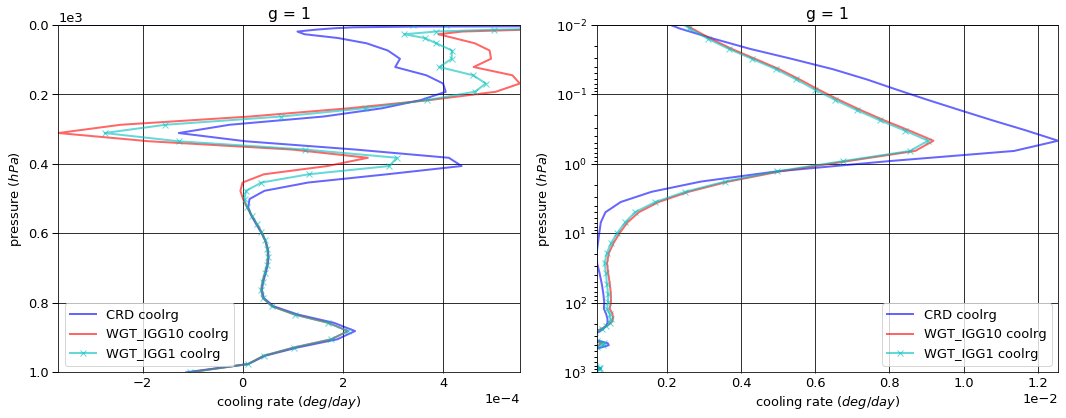

# Figure: cooling rate g-group 2

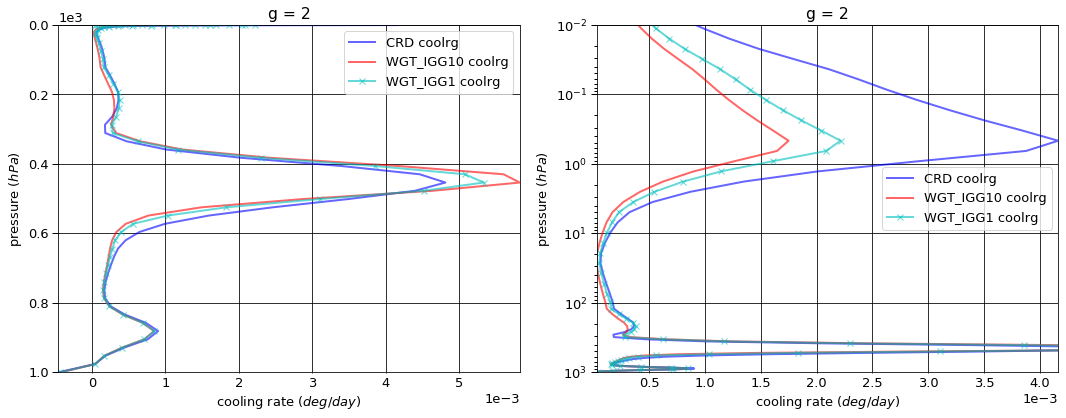

# Figure: cooling rate g-group 3

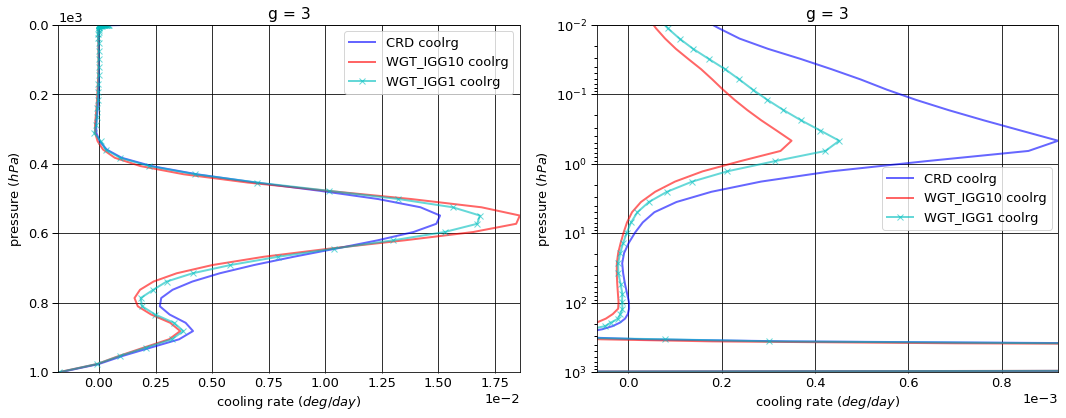

# Figure: cooling rate g-group 4

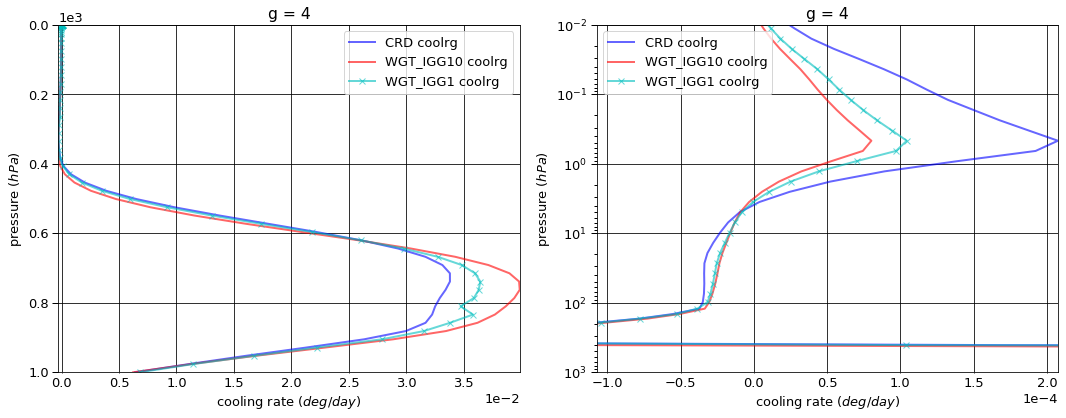

# Figure: cooling rate g-group 5

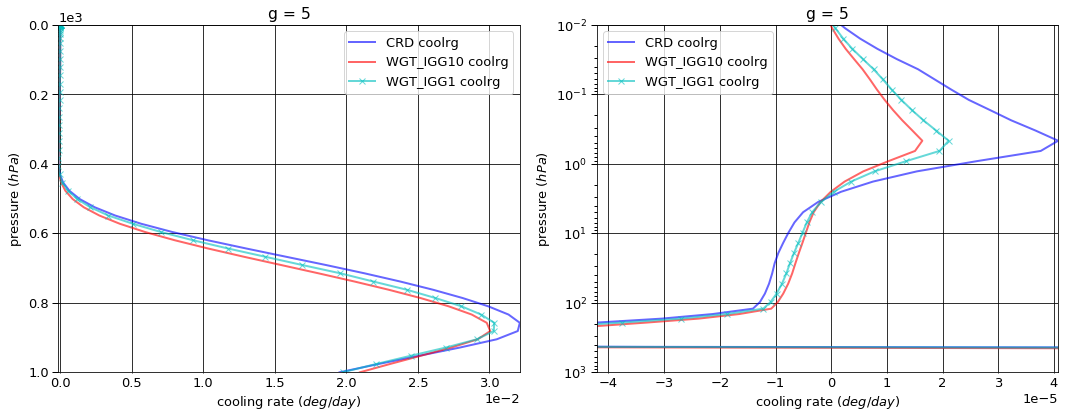

# Figure: cooling rate g-group 6

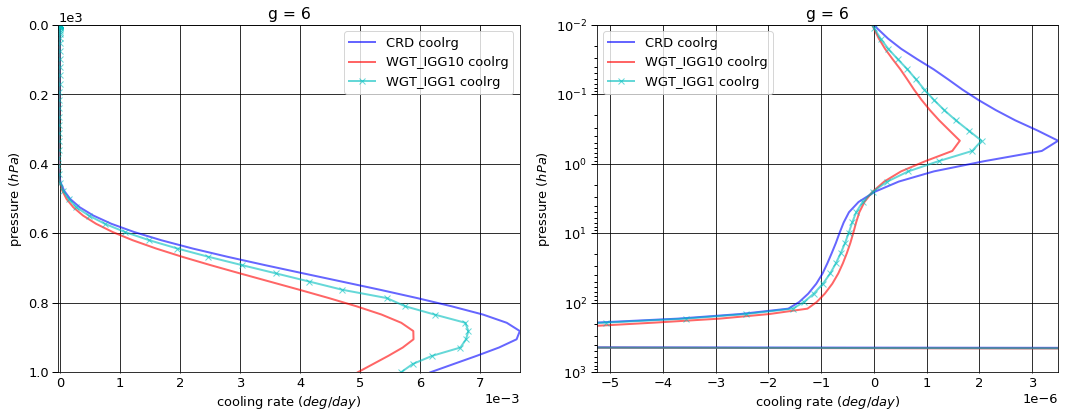

# Figure: cooling rate g-group 7

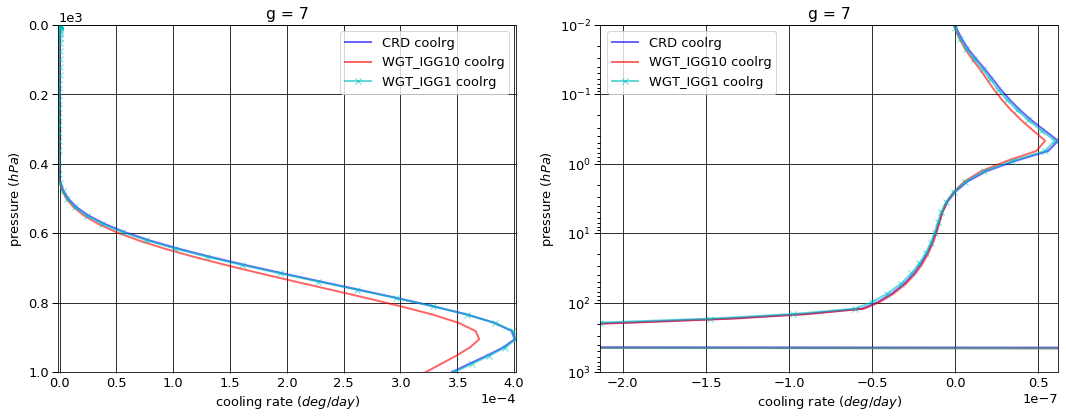

# Figure: cooling rate g-group total

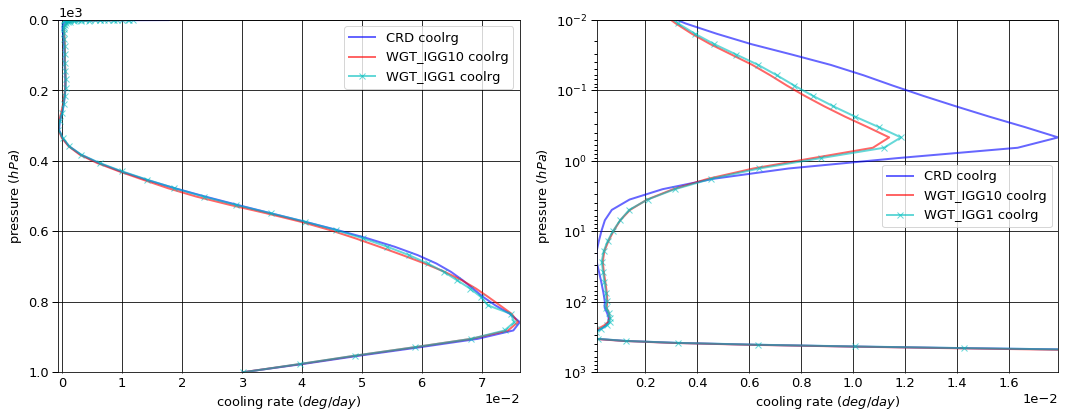

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.018204  0.000000 -0.018204
  1013.0   76    -0.066976  0.067689  0.000713
2 0.0      1     -0.105583  0.000000 -0.105583
  1013.0   76    -0.269656  0.272543  0.002887
3 0.0      1     -0.458636  0.000000 -0.458636
  1013.0   76    -0.758723  0.771820  0.013097
4 0.0      1     -1.660570  0.000000 -1.660570
  1013.0   76    -1.967298  1.818383 -0.148915
5 0.0      1     -2.784910  0.000000 -2.784910
  1013.0   76    -2.882439  1.304226 -1.578213
6 0.0      1     -2.857356  0.000000 -2.857356
  1013.0   76    -2.869960  0.284307 -2.585653
7 0.0      1     -0.742461  0.000000 -0.742461
  1013.0   76    -0.742979  0.014453 -0.728526


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017800  0.000000 -0.017800
  1013.0   76    -0.066251  0.066921  0.000670
2 0.0      1     -0.104137  0.000000 -0.104137
  1013.0   76    -0.267505  0.270211  0.002706
3 0.0      1     -0.457495  0.000000 -0.457495
  1013.0   76    -0.753984  0.765603  0.011618
4 0.0      1     -1.680107  0.000000 -1.680107
  1013.0   76    -1.956854  1.911979 -0.044875
5 0.0      1     -2.810132  0.000000 -2.810132
  1013.0   76    -2.880175  1.167517 -1.712659
6 0.0      1     -2.874569  0.000000 -2.874569
  1013.0   76    -2.883658  0.216246 -2.667412
7 0.0      1     -0.749126  0.000000 -0.749126
  1013.0   76    -0.749603  0.013204 -0.736399


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.018046  0.000000 -0.018046
  1013.0   76    -0.066251  0.066921  0.000670
2 0.0      1     -0.104277  0.000000 -0.104277
  1013.0   76    -0.267505  0.270220  0.002715
3 0.0      1     -0.456219  0.000000 -0.456219
  1013.0   76    -0.753984  0.766138  0.012154
4 0.0      1     -1.665945  0.000000 -1.665945
  1013.0   76    -1.956854  1.869155 -0.087698
5 0.0      1     -2.794789  0.000000 -2.794789
  1013.0   76    -2.880175  1.220747 -1.659428
6 0.0      1     -2.872150  0.000000 -2.872150
  1013.0   76    -2.883658  0.254349 -2.629309
7 0.0      1     -0.749072  0.000000 -0.749072
  1013.0   76    -0.749603  0.014411 -0.735192


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000404  0.000000  0.000404
  1013.0   76     0.000725 -0.000769 -0.000044
2 0.0      1      0.001447  0.000000  0.001447
  1013.0   76     0.002151 -0.002332 -0.000180
3 0.0      1      0.001141  0.000000  0.001141
  1013.0   76     0.004739 -0.006217 -0.001479
4 0.0      1     -0.019538  0.000000 -0.019538
  1013.0   76     0.010444  0.093596  0.104041
5 0.0      1     -0.025223  0.000000 -0.025223
  1013.0   76     0.002263 -0.136710 -0.134446
6 0.0      1     -0.017213  0.000000 -0.017213
  1013.0   76    -0.013698 -0.068061 -0.081759
7 0.0      1     -0.006665  0.000000 -0.006665
  1013.0   76    -0.006624 -0.001249 -0.007873


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000158  0.000000  0.000158
  1013.0   76     0.000725 -0.000769 -0.000044
2 0.0      1      0.001307  0.000000  0.001307
  1013.0   76     0.002151 -0.002323 -0.000172
3 0.0      1      0.002417  0.000000  0.002417
  1013.0   76     0.004739 -0.005681 -0.000943
4 0.0      1     -0.005376  0.000000 -0.005376
  1013.0   76     0.010444  0.050773  0.061217
5 0.0      1     -0.009879  0.000000 -0.009879
  1013.0   76     0.002263 -0.083479 -0.081216
6 0.0      1     -0.014794  0.000000 -0.014794
  1013.0   76    -0.013698 -0.029958 -0.043656
7 0.0      1     -0.006610  0.000000 -0.006610
  1013.0   76    -0.006624 -0.000042 -0.006667

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.207770e-03
  1001.112500 75    -1.128808e-04
2 0.000312    1      4.109031e-06
  1001.112500 75    -4.576798e-04
3 0.000312    1     -7.754860e-06
  1001.112500 75    -1.723770e-03
4 0.000312    1     -3.252303e-05
  1001.112500 75     6.377871e-03
5 0.000312    1     -8.426486e-06
  1001.112500 75     1.952531e-02
6 0.000312    1     -6.225626e-07
  1001.112500 75     6.170436e-03
7 0.000312    1     -8.528790e-09
  1001.112500 75     3.451139e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.807081e-04
  1001.112500 75    -1.057275e-04
2 0.000312    1      1.364673e-05
  1001.112500 75    -4.273425e-04
3 0.000312    1     -1.876291e-05
  1001.112500 75    -1.795834e-03
4 0.000312    1     -1.716616e-05
  1001.112500 75     6.221865e-03
5 0.000312    1     -4.343144e-06
  1001.112500 75     2.094942e-02
6 0.000312    1     -3.215243e-07
  1001.112500 75     4.960797e-03
7 0.000312    1     -7.925380e-09
  1001.112500 75     3.219895e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.408366e-04
  1001.112500 75    -1.057275e-04
2 0.000312    1      3.513880e-05
  1001.112500 75    -4.287908e-04
3 0.000312    1     -1.626017e-05
  1001.112500 75    -1.777550e-03
4 0.000312    1     -1.863086e-05
  1001.112500 75     6.792259e-03
5 0.000312    1     -5.017330e-06
  1001.112500 75     1.974215e-02
6 0.000312    1     -3.944378e-07
  1001.112500 75     5.681194e-03
7 0.000312    1     -8.746437e-09
  1001.112500 75     3.470534e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.588479e-03
  1001.112500 75     7.153330e-06
2 0.000312    1      9.537701e-06
  1001.112500 75     3.033727e-05
3 0.000312    1     -1.100805e-05
  1001.112500 75    -7.206370e-05
4 0.000312    1      1.535687e-05
  1001.112500 75    -1.560058e-04
5 0.000312    1      4.083342e-06
  1001.112500 75     1.424103e-03
6 0.000312    1      3.010383e-07
  1001.112500 75    -1.209639e-03
7 0.000312    1      6.034096e-10
  1001.112500 75    -2.312435e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.548607e-03
  1001.112500 75     7.153330e-06
2 0.000312    1      3.102977e-05
  1001.112500 75     2.888900e-05
3 0.000312    1     -8.505306e-06
  1001.112500 75    -5.377940e-05
4 0.000312    1      1.389216e-05
  1001.112500 75     4.143883e-04
5 0.000312    1      3.409156e-06
  1001.112500 75     2.168370e-04
6 0.000312    1      2.281249e-07
  1001.112500 75    -4.892424e-04
7 0.000312    1     -2.176478e-10
  1001.112500 75     1.939480e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.62772,0.000000,-8.62772
1013.0,76,-9.55803,4.533421,-5.02461



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.693367,0.00000,-8.693367
1013.0,76,-9.558030,4.41168,-5.146350



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.660497,0.000000,-8.660497
1013.0,76,-9.558030,4.461941,-5.096089



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.564678e-02,0.000000,-0.065647
1013.0,76,2.999998e-09,-0.121741,-0.121741



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.277738e-02,0.00000,-0.032777
1013.0,76,2.999998e-09,-0.07148,-0.071480


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001253
1001.112500,75,0.030124



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000354
1001.112500,75,0.030125



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000336
1001.112500,75,0.030251



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,1.606750e-03
1001.112500,75,7.610500e-07



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001589
1001.112500,75,0.000126


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008727,0.006931
2,0.033164,0.027987
3,0.090315,0.078885
4,0.229558,0.204734
5,0.305091,0.301336
6,0.269358,0.301700
7,0.063788,0.078427


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.634434e-20
2,2.348017e-21
3,3.373146e-22
4,4.845840e-23
5,6.961502e-24
6,1.000085e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.634434e-20,NaN,0.008727,0.006931,0.008727,0.006931,600.0
2,2.348017e-21,0.143659,0.033164,0.027987,0.041891,0.034919,600.0
3,3.373146e-22,0.143659,0.090315,0.078885,0.132206,0.113804,600.0
4,4.845840e-23,0.143659,0.229558,0.204734,0.361764,0.318538,600.0
5,6.961502e-24,0.143659,0.305091,0.301336,0.666855,0.619873,600.0
6,1.000085e-24,0.143659,0.269358,0.301700,0.936212,0.921573,600.0
7,1.858499e-25,0.185834,0.063788,0.078427,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
